## Process Discovery

Now we have extracted and preprocessed our event logs, we can begin process mining!

The first investigation step in process mining is process discovery (as seen in the PM$^2$ methodology <sup>[1]</sup>), where we produce views of the processes in the event log and filter down to focus on specific sub processes.

[1]Van Eck, M. L., Lu, X., Leemans, S. J. & Van Der Aalst, W. M. (2015), Pm: a process mining project
methodology, in ‘International conference on advanced information systems engineering’, Springer, pp. 297–
313.

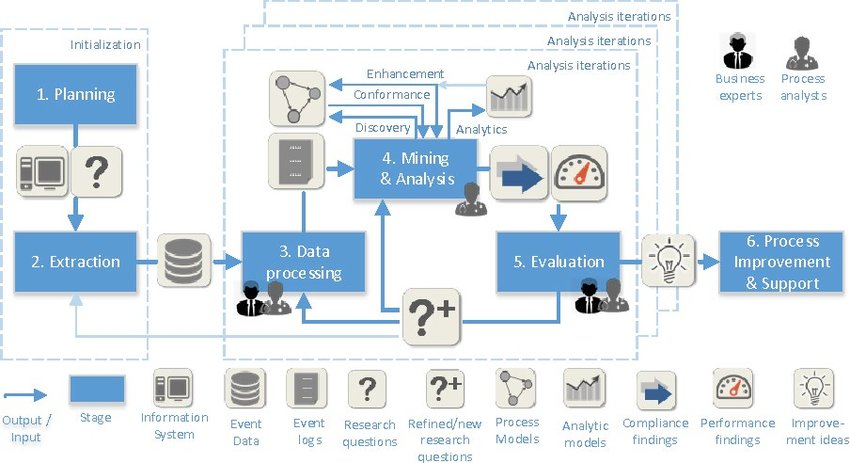

In [79]:
from IPython.display import Image, display
display(Image(filename='PM2_Process-Mining-Project-Methodology.png'))

In python we import open source packages with useful functions that will facillitate our programming

In [80]:
import pandas as pd
import re
import numpy as np
import pm4py
import seaborn as sns
from matplotlib import pyplot as plt
import math

We download our pre-prepared event log

In [81]:
EL_df0=pd.read_csv('EventLogWAttsBusRules.csv')
EL_df0[['Timestamp']] = EL_df0[['Timestamp']].apply(pd.to_datetime, errors='coerce')
EL_df0.Patient_ID.nunique()

5435

We are going to perform many transformatins on our event log so it is smart to make a copy now so that we can revert any changes if required by rerunning the below cell.

In [82]:
EL_df1=EL_df0.copy()

Disocvery is all about exactly that, discovering. Therefore we can start investgating anything and everything. 

We can start simple and do a count of the number of each activity in the event log.

In [83]:
EL_df1["Activity"].value_counts()

Incident_Time      5435
Originated         5435
Mobile             5435
Arrive_scene       5435
First_NEWS_Time    5435
LAST_NEWS_Time     5435
Depart_scene       5435
Arrive_dest        5435
Care_transfer      5435
Name: Activity, dtype: int64

Calculating the time of each activity from the beginning of its respective case allows us to view patterns in the duration and timings of events. The next few cells calsalte these timings.

In [84]:
case_starts_ends = EL_df1.pivot_table(index='Patient_ID', aggfunc={'Timestamp': ['min', 'max']})# find mininum and maximum time of each patient
case_starts_ends = case_starts_ends.reset_index() #rest index to not be patient
case_starts_ends.columns = ['Patient_ID', 'caseend', 'casestart'] # rename columns

In [85]:
EL_df1 = EL_df1.merge(case_starts_ends, on='Patient_ID') # merge tales on index patient
EL_df1['caselength'] = EL_df1['caseend'] - EL_df1['casestart']
EL_df1['relativetime'] = EL_df1['Timestamp'] - EL_df1['casestart']
EL_df1['relativetime_s'] = EL_df1['relativetime'].dt.seconds + 86400*EL_df1['relativetime'].dt.days

In [86]:
EL_df1=EL_df1.merge(EL_df1[(EL_df1['Activity']=='Arrive_scene') ][['Patient_ID','relativetime_s']].rename(columns={"relativetime_s":"Response_Time"}),on='Patient_ID',how='left')
EL_df1['hour'] = EL_df1['Timestamp'].apply(lambda x: x.time().hour)

The process mining package in python (pm4py) has many vislual producing subpackeges taht require our evnt og to be in a specific format. The below code formats the log into the reqired object type

In [87]:
EL_df1 = pm4py.format_dataframe(EL_df1,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
Log = pm4py.convert_to_event_log(EL_df1)

C:\Users\User\AppData\Local\Temp\ipykernel_4408\1381486275.py:1: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  EL_df1 = pm4py.format_dataframe(EL_df1,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


Lets invetstigate when the jobycyle events hapned in the day, week and year

Turn Dataframe to Log Format

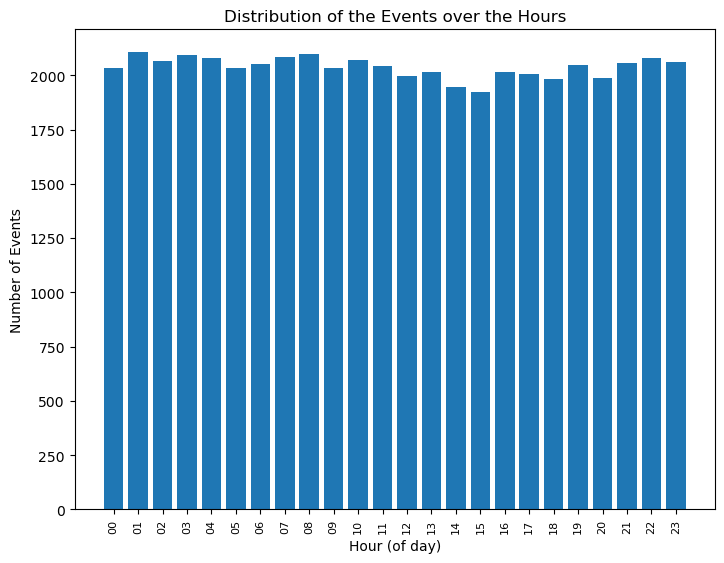

In [88]:
pm4py.view_events_distribution_graph(EL_df1, distr_type="hours")

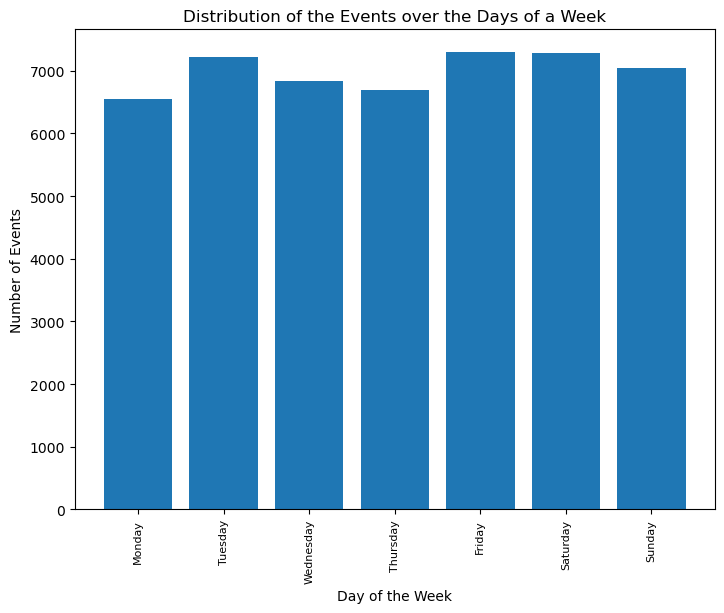

In [89]:
pm4py.view_events_distribution_graph(EL_df1, distr_type="days_week")

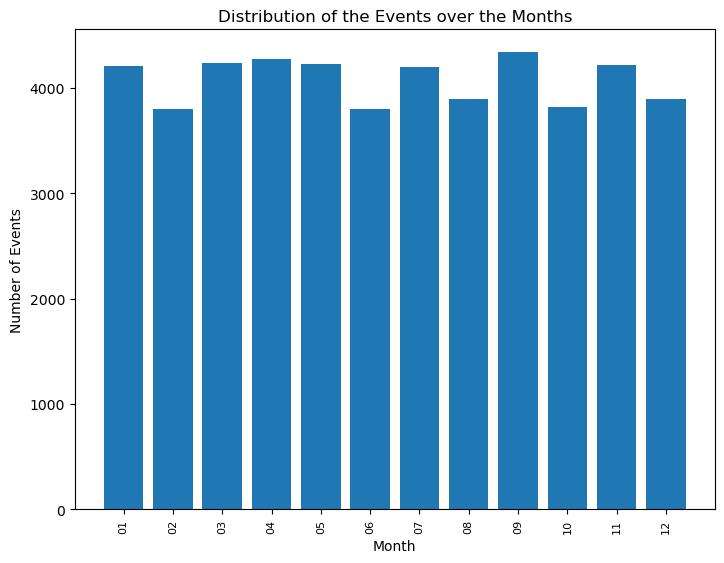

In [90]:
pm4py.view_events_distribution_graph(EL_df1, distr_type="months")

A common graph to use in process mining is called a dotted graph and allows you to view events and cases in a variety of different ways. Here we use one to show cases in duration order with the shortest cases at the top and the longest cases towards the bottom of the graph.

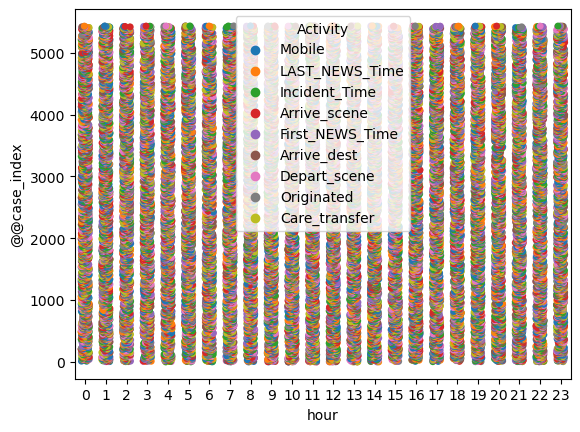

In [91]:
ax = sns.stripplot(x=EL_df1['hour'], y=EL_df1['@@case_index'], hue=EL_df1['Activity'], jitter=0.2)

In [92]:
patientnums = [int(e) for e in EL_df1['@@case_index']]
ordered = EL_df1.sort_values(by=['caselength', '@@case_index', 'relativetime_s'],ascending=False)
from itertools import groupby
grouped = [list(g) for k, g in groupby(ordered['@@case_index'].tolist())]
ordered['new_index']=np.repeat(range(len(grouped)),[len(x) for x in grouped])+1
ordered['relativetime_m']=ordered['relativetime_s']/60

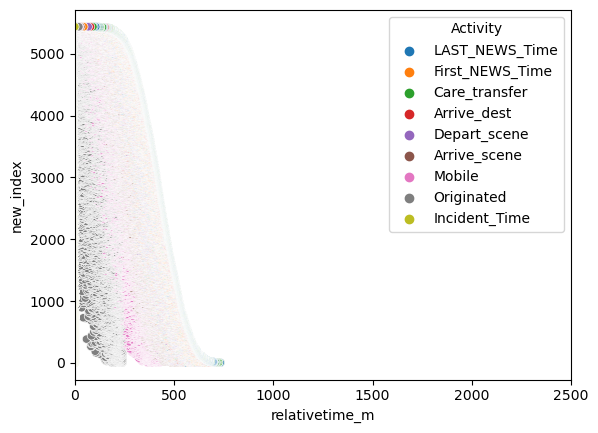

In [93]:
%matplotlib inline
ax = sns.scatterplot(x=ordered['relativetime_m'], y=ordered['new_index'], hue=ordered['Activity'])
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.xlim(0,2500)
#plt.ylim(math.ceil(np.max(ordered['new_index'])/2),np.max(ordered['new_index']))
plt.show()

Another useful graph is a density plot of duration. We can show this in conjunction with a boxplot to show the density of case duraton in the event log. Ths kind of plot can show pattern cand differences in case duration which may prompt further investigation.

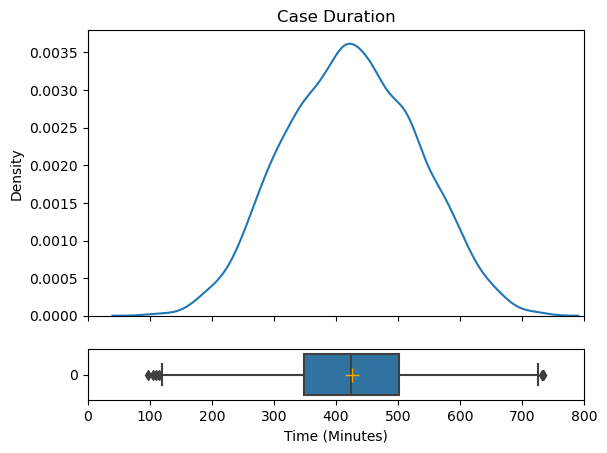

In [94]:
traceduration=pm4py.stats.get_all_case_durations(Log)
timemins = [x / (60) for x in traceduration]

f, (ax_dens,ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
sns.kdeplot(timemins,ax=ax_dens)
sns.boxplot(timemins,ax=ax_box , orient="h",showmeans=True, meanprops={"marker": "+","markeredgecolor": "orange","markersize": "10"})
plt.xlim(0,800)
ax_dens.set(xlabel='')
ax_dens.set(title='Case Duration')
ax_box.set(xlabel='Time (Minutes)')
plt.show()

Now we will move into process mining specifc techniques to investiagte the event log.

The order of events in which a case navigates a process is known as a trace. Each unique trace is also known as a variant. If there are multiples cases that have identical traces, we say they share a single variant. The number of variants is always equal to or less than the number of cases. We can measure the number of variants in the event log and how many cases they account for.

In [95]:
variants = pm4py.get_variants(Log)
variantseq=['_'.join(i) for i in variants]
varperclog=[len(variants[i])/EL_df1.Patient_ID.nunique()*100 for i in variants]

VPL={'Variant':variantseq,'Percenatge of Log':varperclog}
VPL_df = pd.DataFrame(VPL)
VPL_df=VPL_df.sort_values('Percenatge of Log',axis=0, ascending=False)
print(len(variants))
VPL_df.head(30)

10


,Variant,Percenatge of Log
0,Incident_Time_Originated_Mobile_Arrive_scene_D...,34.774609
3,Incident_Time_Originated_Mobile_Arrive_scene_F...,21.085557
2,Incident_Time_Originated_Mobile_Arrive_scene_D...,12.180313
1,Incident_Time_Originated_Mobile_Arrive_scene_F...,10.726771
5,Incident_Time_Originated_Mobile_Arrive_scene_D...,9.273229
6,Incident_Time_Originated_Mobile_Arrive_scene_D...,4.710212
4,Incident_Time_Originated_Mobile_Arrive_scene_D...,3.477461
7,Incident_Time_Originated_Mobile_Arrive_scene_F...,2.042318
8,Incident_Time_Originated_Mobile_Arrive_scene_F...,1.232751
9,Incident_Time_Originated_Mobile_Arrive_scene_D...,0.496780


Now we will view these variants in our first process mining specific graph known as a directly follows graph (DFG).

This DFG shows every consecutive combination of activties with an edge between two nodes (activities) with the number of caes following each consecutive activity path shown in an annontated value next to each edge. 


View Frequency DFG of Entire Log

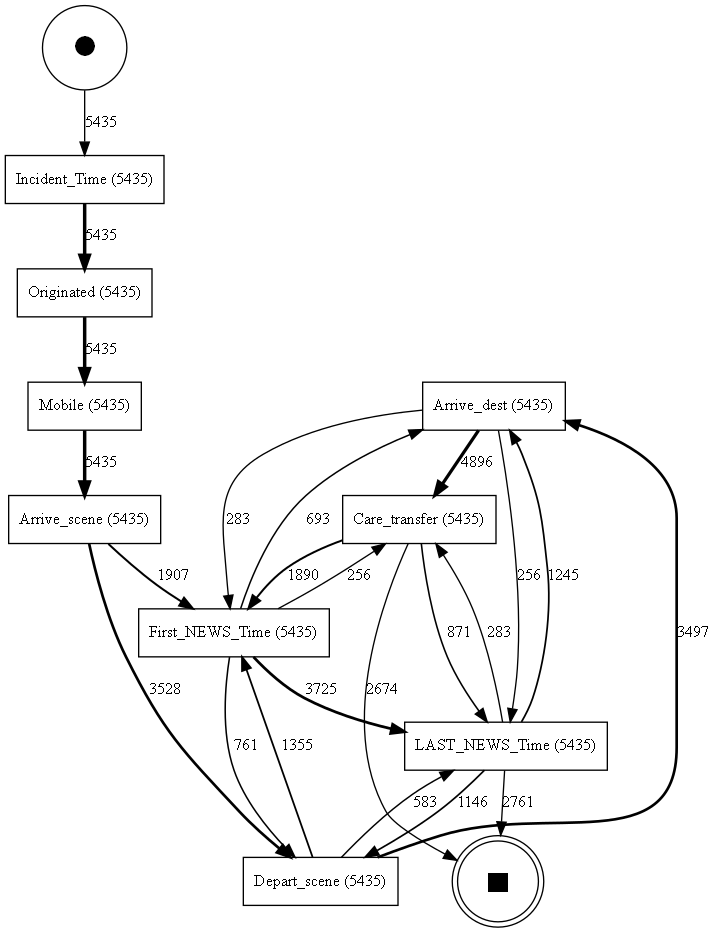

In [96]:
dfg, start_activities, end_activities = pm4py.discover_dfg(Log)

pm4py.view_dfg(dfg, start_activities, end_activities)

We can apply a number of different filters to the log to produce different DFGs. Here we filter to show only the top two most common variants.

C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


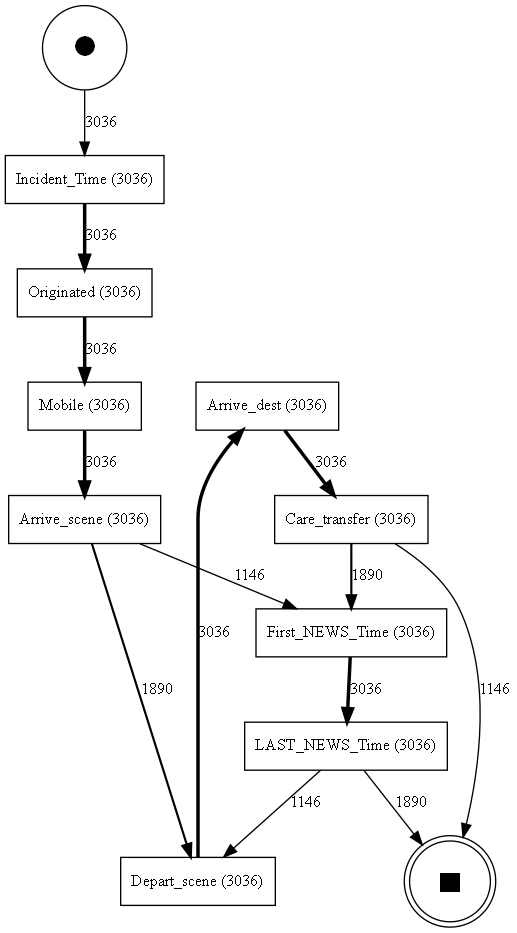

In [97]:
top2variants=pm4py.filter_variants_top_k(Log,2)

dfg, start_activities, end_activities = pm4py.discover_dfg(top2variants)

pm4py.view_dfg(dfg, start_activities, end_activities)

### Remove Events

Some events like NEWS add variation which can impede investigations for some research questions, for exampe if we wanted to only see the time between the events showing the prgress of the ambualnce through the job cycle.

Here we remove the recoding of NEWs from the job cycle.

In [98]:
EL_dropped_df1=EL_df1.drop(EL_df1[(EL_df1['Activity'] == 'First_NEWS_Time')|(EL_df1['Activity'] == 'LAST_NEWS_Time')].index)
EL_dropped_df1.head(10)

,Unnamed: 0,Patient_ID,Activity,Timestamp,Age,Sex,Ethnicity,Incident_Postcode,Clinical Category,Highest Technician on Scene,...,caselength,relativetime,relativetime_s,Response_Time,hour,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,891,100,Incident_Time,2033-06-11 04:25:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 00:00:00,0,26280,4,100,Incident_Time,2033-06-11 04:25:48.689667,0,0
1,892,100,Originated,2033-06-11 08:12:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 03:47:00,13620,26280,8,100,Originated,2033-06-11 08:12:48.689667,1,0
2,893,100,Mobile,2033-06-11 10:52:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 06:27:00,23220,26280,10,100,Mobile,2033-06-11 10:52:48.689667,2,0
3,894,100,Arrive_scene,2033-06-11 11:43:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 07:18:00,26280,26280,11,100,Arrive_scene,2033-06-11 11:43:48.689667,3,0
4,895,100,Depart_scene,2033-06-11 12:33:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 08:08:00,29280,26280,12,100,Depart_scene,2033-06-11 12:33:48.689667,4,0
5,896,100,Arrive_dest,2033-06-11 13:24:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 08:59:00,32340,26280,13,100,Arrive_dest,2033-06-11 13:24:48.689667,5,0
6,897,100,Care_transfer,2033-06-11 13:34:48.689667,96,Female,White,DE7,Mental Health,Paramedic,...,0 days 10:29:00,0 days 09:09:00,32940,26280,13,100,Care_transfer,2033-06-11 13:34:48.689667,6,0
9,8991,1000,Incident_Time,2033-06-09 05:44:37.296097,52,Female,White,S41,Cardiovascular,Paramedic,...,0 days 07:46:00,0 days 00:00:00,0,18660,5,1000,Incident_Time,2033-06-09 05:44:37.296097,9,1
10,8992,1000,Originated,2033-06-09 07:51:37.296097,52,Female,White,S41,Cardiovascular,Paramedic,...,0 days 07:46:00,0 days 02:07:00,7620,18660,7,1000,Originated,2033-06-09 07:51:37.296097,10,1
11,8993,1000,Mobile,2033-06-09 09:43:37.296097,52,Female,White,S41,Cardiovascular,Paramedic,...,0 days 07:46:00,0 days 03:59:00,14340,18660,9,1000,Mobile,2033-06-09 09:43:37.296097,11,1


In [99]:
print('Mean job cycle response time (minutes) from fake data: ', EL_dropped_df1["Response_Time"].mean()/60)
print('Median job cycle response time (minutes) from fake data: ', EL_dropped_df1["Response_Time"].median()/60)

Mean job cycle response time (minutes) from fake data:  278.7954001839926
Median job cycle response time (minutes) from fake data:  278.0


For Category 2 amabulance calls (the majority catgeory of call), there is a mean response time target of 18 minutes. We cans see the job cycles thhat have a respsone time less than and greater then this eman target by filitering the log and viewing tehir DFGs.

In [100]:
filter18orless = EL_dropped_df1[EL_dropped_df1["Response_Time"]<=18*60]
filter18ormore = EL_dropped_df1[EL_dropped_df1["Response_Time"]>18*60]

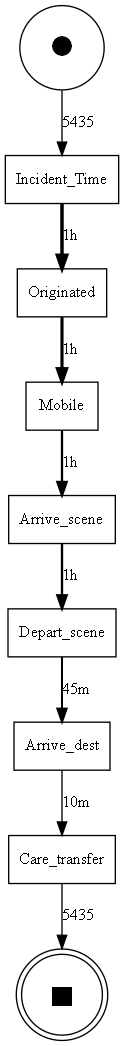

In [101]:
dfg, start_activities, end_activities = pm4py.discover_performance_dfg(filter18orless)
pm4py.view_performance_dfg(dfg, start_activities, end_activities)

dfg, start_activities, end_activities = pm4py.discover_performance_dfg(filter18ormore )
pm4py.view_performance_dfg(dfg, start_activities, end_activities)

### Add Outcomes as Events

The outcome of a patient for example if they were treated and transported to hospital or referred to a different medical center etc. These are not technically activities or events in the job cycle however we can add them in as a proxy activity at the end of a case by puutting them noe second after each cases final activity. 

As we are performing more transformations on the event log, we make another copy so that we can revert changes if needed.


In [102]:
EL_df2=EL_df0.copy()

find index of final event of all traces and find the traces outcome

In [103]:
x=[]
x=[np.max(EL_df2.index[EL_df2['Patient_ID']==i].tolist()) for i in EL_df2.Patient_ID.unique()]
ELend_df = EL_df2.iloc[EL_df2.index.isin(x)]
ELend_df['Activity']=ELend_df['Outcome']

C:\Users\User\AppData\Local\Temp\ipykernel_4408\2563771931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ELend_df['Activity']=ELend_df['Outcome']


insert the outcome as an event with a timestamp of each traces last event + 1 second

In [104]:
ELend_df['Timestamp']=ELend_df['Timestamp'] + pd.Timedelta(1,'s')
EL_df2=pd.concat([EL_df2, ELend_df], axis=0)
EL_df2= EL_df2.sort_values(['Patient_ID','Timestamp'])

C:\Users\User\AppData\Local\Temp\ipykernel_4408\985259418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ELend_df['Timestamp']=ELend_df['Timestamp'] + pd.Timedelta(1,'s')


We turn it into a log object with the pm4py package

In [105]:
#EL_dropped_df2=EL_df2.drop(EL_df2[(EL_df2['Activity'] == 'First_NEWS_Time')|(EL_df2['Activity'] == 'LAST_NEWS_Time')].index)
EL_df2 = pm4py.format_dataframe(EL_df2,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
EL_Outcome_log = pm4py.convert_to_event_log(EL_df2)

C:\Users\User\AppData\Local\Temp\ipykernel_4408\12496872.py:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  EL_df2 = pm4py.format_dataframe(EL_df2,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


We can view these outcomes

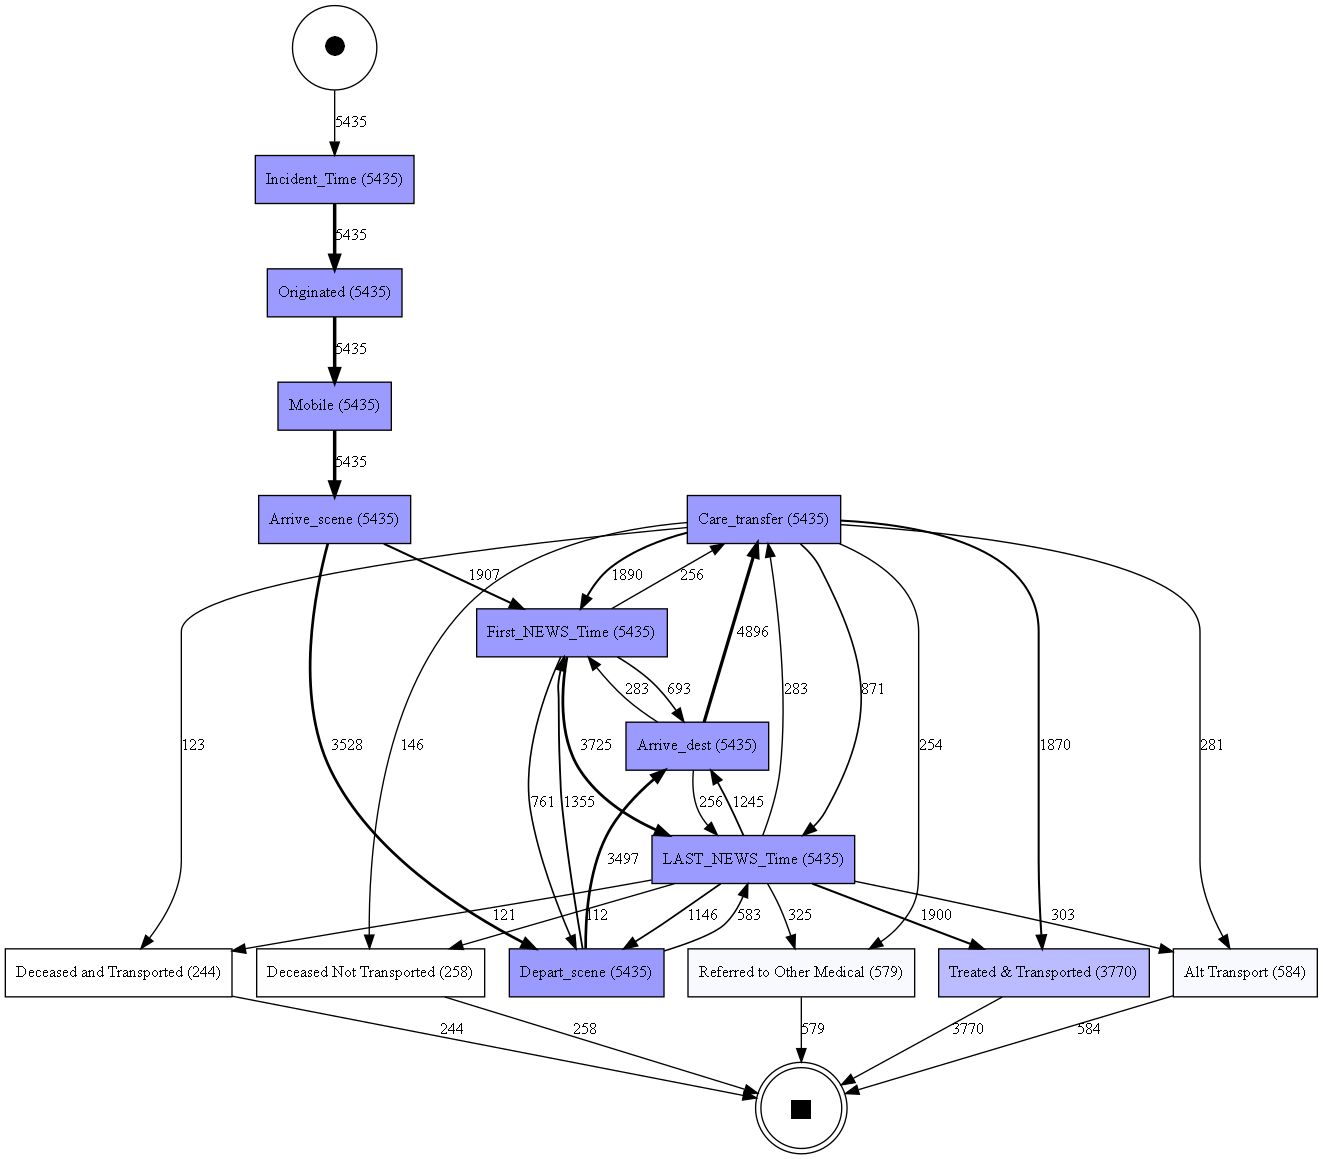

In [106]:
dfg, start_activities, end_activities = pm4py.discover_dfg(EL_Outcome_log)

pm4py.view_dfg(dfg, start_activities, end_activities)

Here we produce a DFG for each unique outcome with the mean time to get between each activity shown on their respective edges. If this data was real we could compare how the job cycles differed between these clinical categories

Mental Health


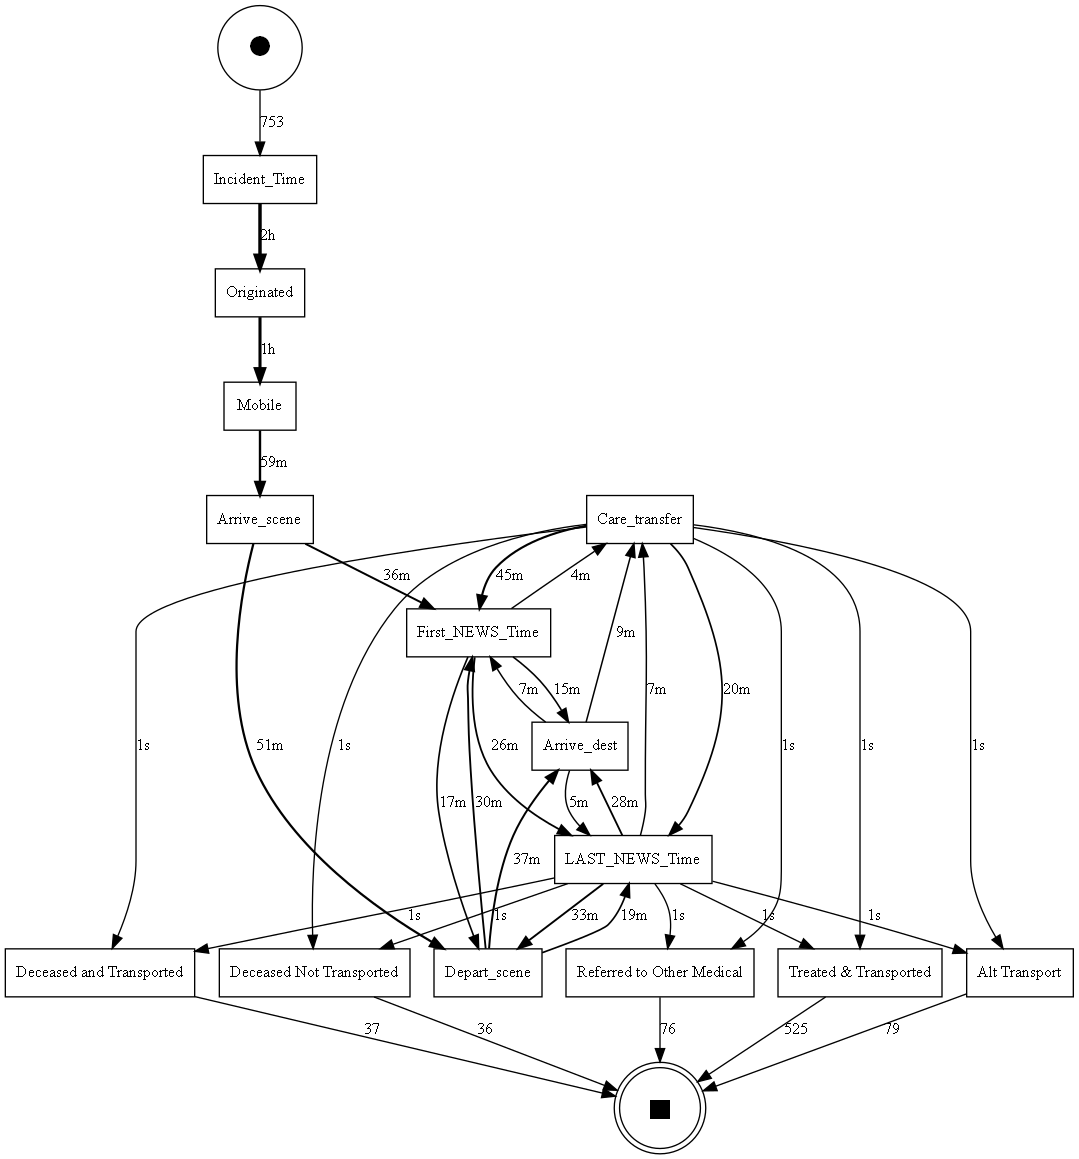

Obs/Gynae


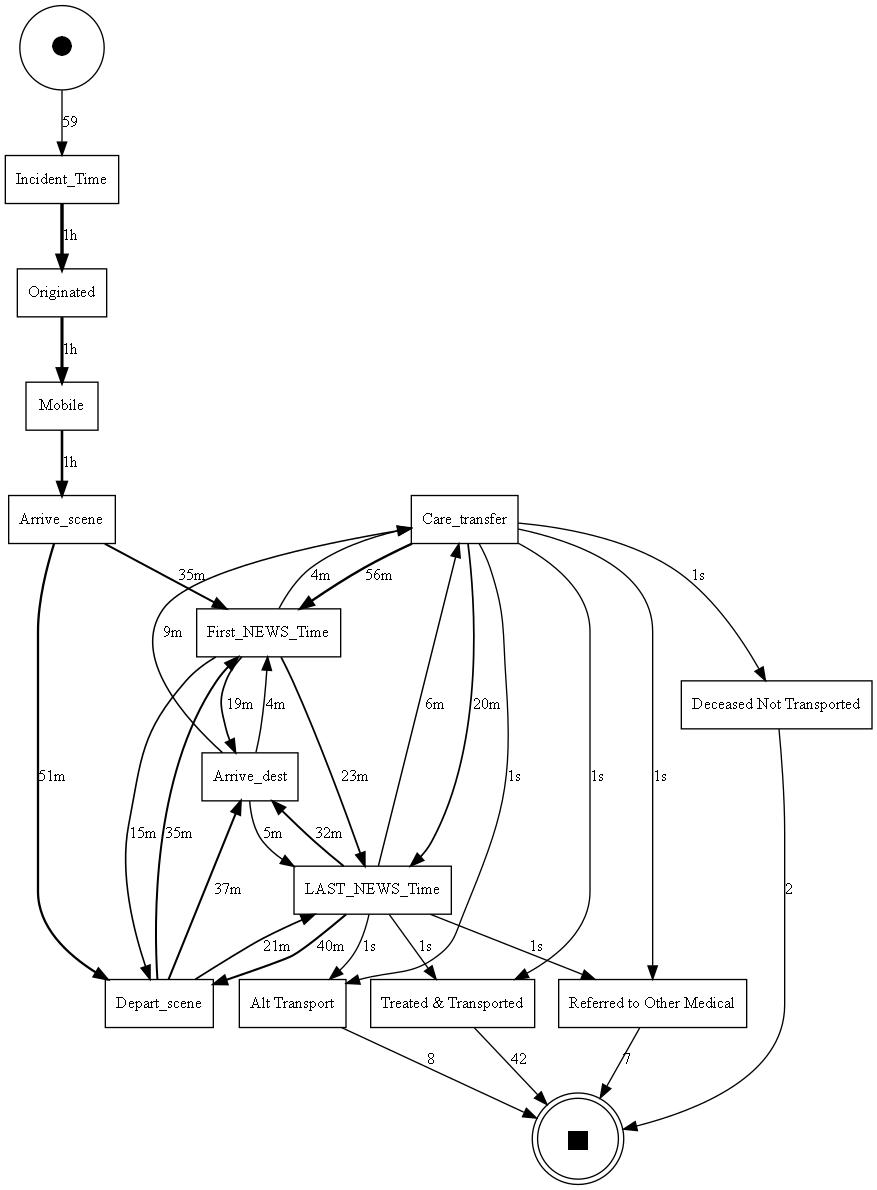

Cardiovascular


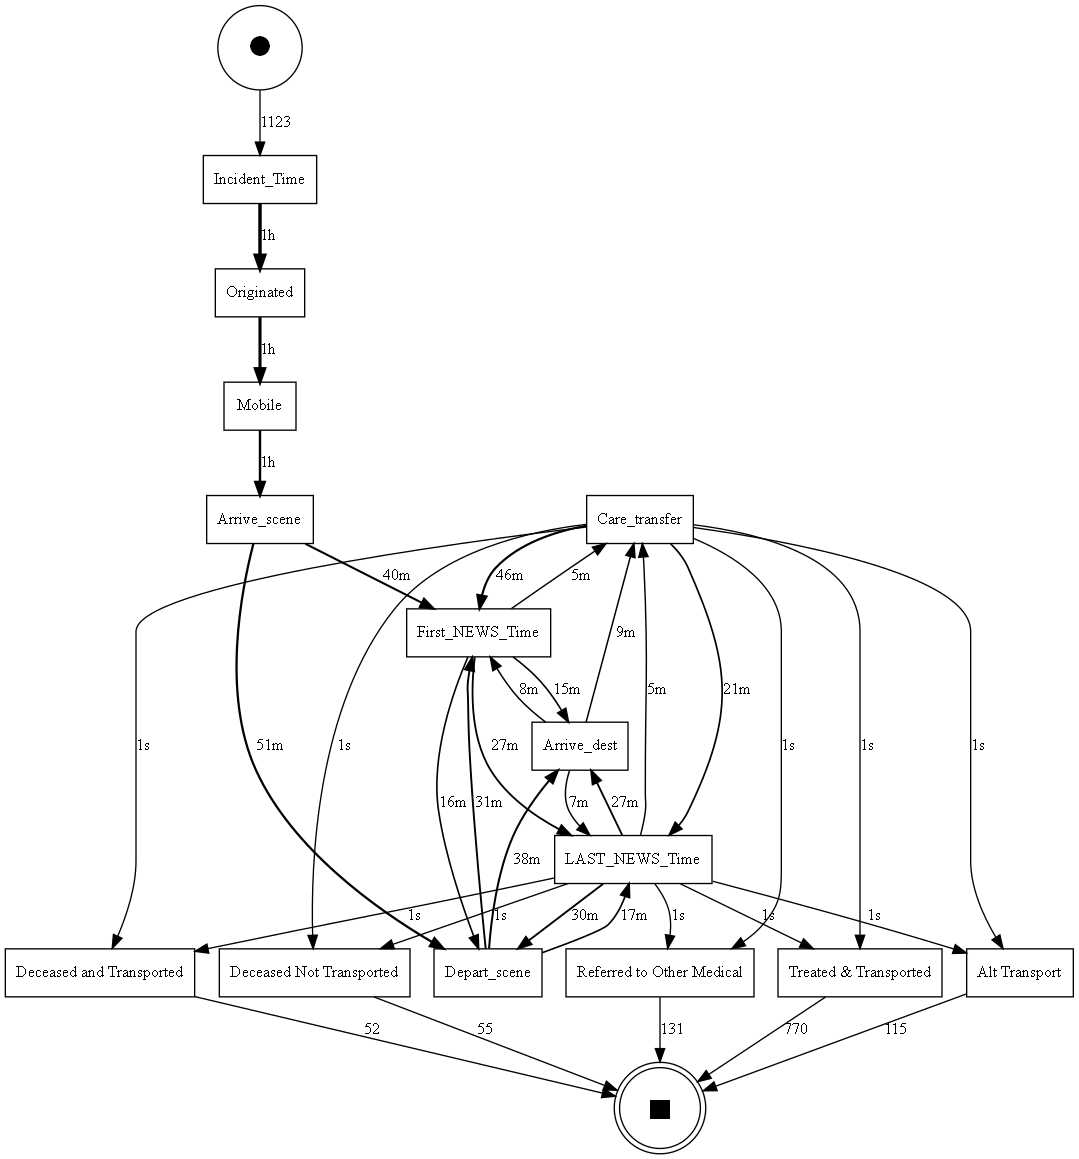

Neurological


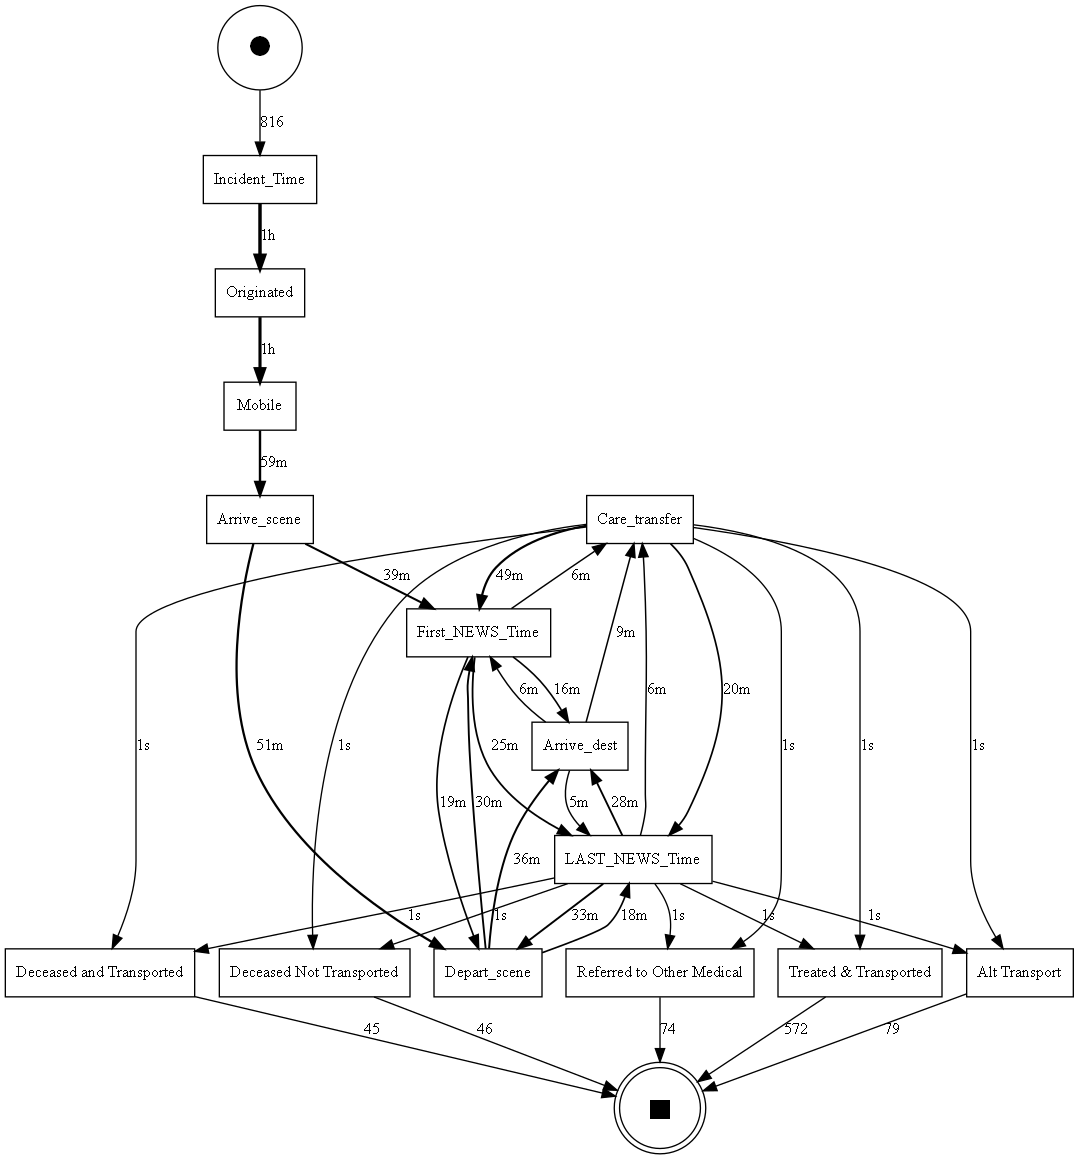

Trauma


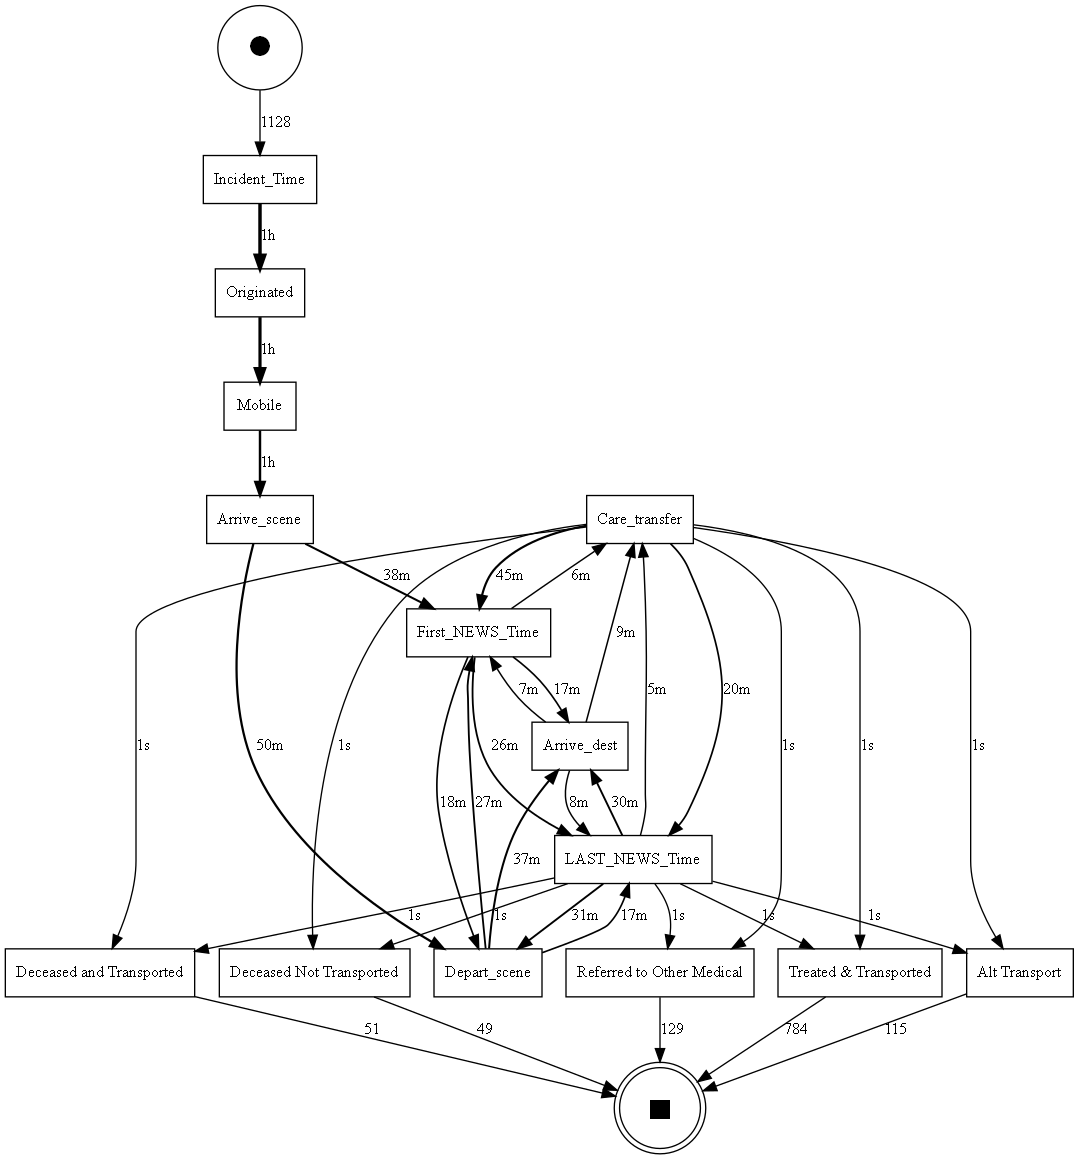

Respiratory


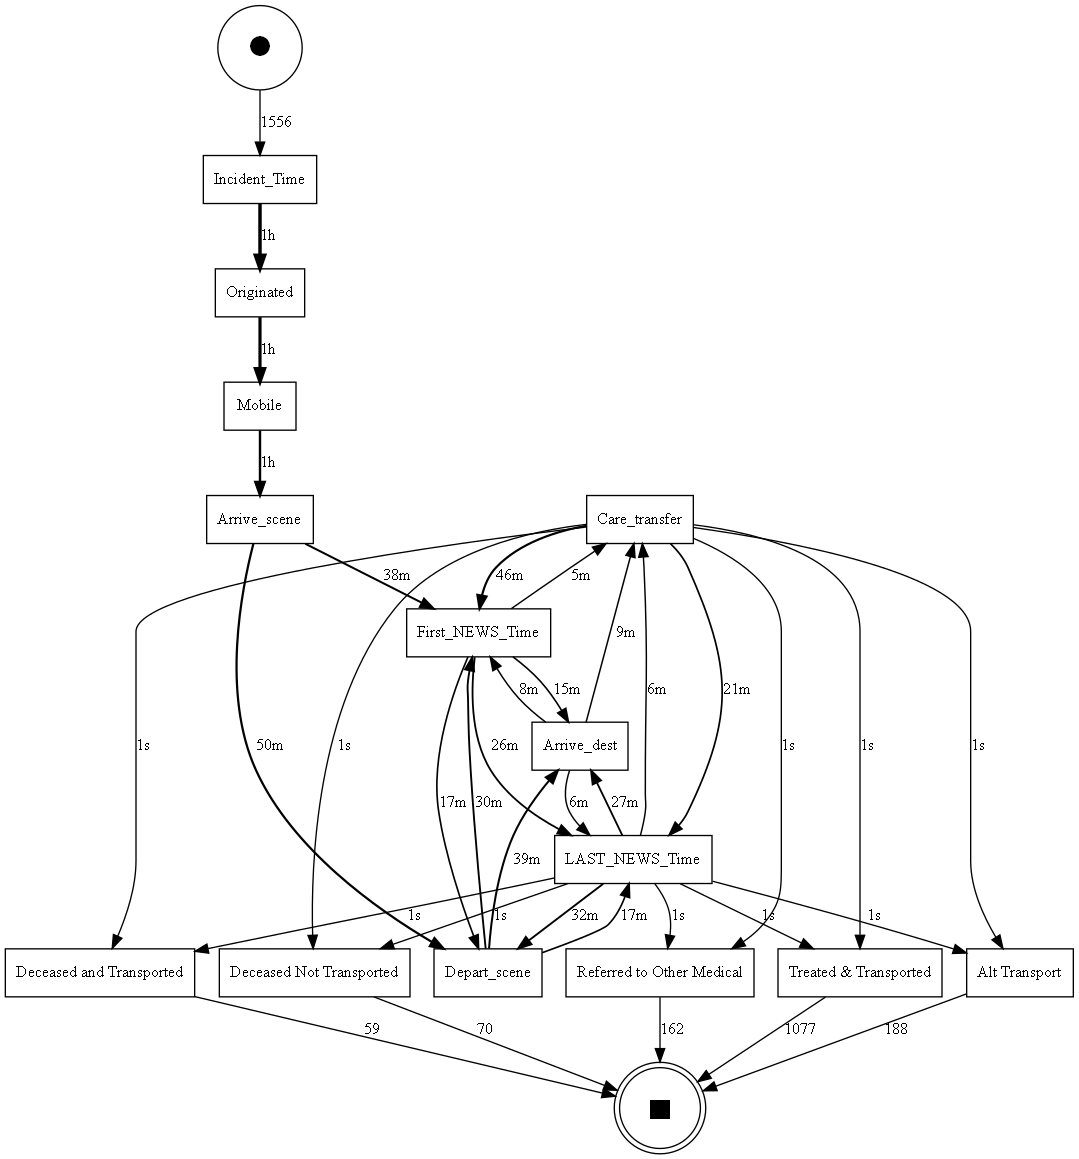

In [108]:
for i in set(EL_df1["Clinical Category"].values):
    print(i)
    category=pm4py.filter_event_attribute_values(EL_Outcome_log, "Clinical Category", [i], level="case", retain=True)
    dfg, start_activities, end_activities = pm4py.discover_performance_dfg(category)
    pm4py.view_performance_dfg(dfg, start_activities, end_activities)
